In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Data Load

In [3]:
market_cap_df = pd.read_csv('/content/Companies_ranked_by_Market_Cap.csv')
earnings_df = pd.read_csv('/content/Companies_ranked_by_Earnings.csv')
revenue_df = pd.read_csv('/content/Companies_ranked_by_Revenue.csv')
pe_ratio_df = pd.read_csv('/content/Companies_ranked_by_P_E_ratio.csv')
dividend_yield_df = pd.read_csv('/content/Companies_ranked_by_Dividend_Yield.csv')

# EDA

In [4]:
print(market_cap_df.head(), market_cap_df.info())
print(earnings_df.head(), earnings_df.info())
print(revenue_df.head(), revenue_df.info())
print(pe_ratio_df.head(), pe_ratio_df.info())
print(dividend_yield_df.head(), dividend_yield_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9912 entries, 0 to 9911
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Rank         9912 non-null   int64  
 1   Name         9912 non-null   object 
 2   Symbol       9911 non-null   object 
 3   marketcap    9912 non-null   float64
 4   price (GBP)  9912 non-null   float64
 5   country      9910 non-null   object 
dtypes: float64(2), int64(1), object(3)
memory usage: 464.8+ KB
   Rank               Name Symbol     marketcap  price (GBP)        country
0     1              Apple   AAPL  2.689903e+12   176.919492  United States
1     2          Microsoft   MSFT  2.427170e+12   326.537958  United States
2     3             NVIDIA   NVDA  2.259353e+12    92.105725  United States
3     4  Alphabet (Google)   GOOG  1.549815e+12   126.458691  United States
4     5             Amazon   AMZN  1.506038e+12   143.492307  United States None
<class 'pandas.core.frame.DataFra

In [5]:
print(market_cap_df.isnull().sum())
print(earnings_df.isnull().sum())
print(revenue_df.isnull().sum())
print(pe_ratio_df.isnull().sum())
print(dividend_yield_df.isnull().sum())

Rank           0
Name           0
Symbol         1
marketcap      0
price (GBP)    0
country        2
dtype: int64
Rank            0
Name            0
Symbol          1
earnings_ttm    0
price (GBP)     0
country         2
dtype: int64
Rank           0
Name           0
Symbol         1
revenue_ttm    0
price (GBP)    0
country        2
dtype: int64
Rank            0
Name            0
Symbol          1
pe_ratio_ttm    0
price (GBP)     0
country         2
dtype: int64
Rank                  0
Name                  0
Symbol                1
dividend_yield_ttm    0
price (GBP)           0
country               2
dtype: int64


In [6]:
market_cap_df = market_cap_df.dropna(subset=['Symbol', 'country'])
earnings_df = earnings_df.dropna(subset=['Symbol', 'country'])
revenue_df = revenue_df.dropna(subset=['Symbol', 'country'])
pe_ratio_df = pe_ratio_df.dropna(subset=['Symbol', 'country'])
dividend_yield_df = dividend_yield_df.dropna(subset=['Symbol', 'country'])

In [8]:
print(market_cap_df.describe())
print(earnings_df.describe())
print(revenue_df.describe())
print(pe_ratio_df.describe())
print(dividend_yield_df.describe())

              Rank     marketcap   price (GBP)
count  9909.000000  9.909000e+03   9909.000000
mean   4956.438894  8.744509e+09     53.477109
std    2861.386676  5.791520e+10    359.832438
min       1.000000  0.000000e+00      0.000000
25%    2479.000000  2.170231e+08      2.005959
50%    4957.000000  1.067611e+09      8.552696
75%    7434.000000  4.639298e+09     28.817327
max    9912.000000  2.689903e+12  16549.695004
              Rank  earnings_ttm   price (GBP)
count  9909.000000  9.909000e+03   9909.000000
mean   4956.800383  7.113198e+08     53.477189
std    2861.336482  4.204151e+09    359.832842
min       1.000000 -1.730700e+10      0.000000
25%    2480.000000 -4.528400e+06      2.005959
50%    4957.000000  5.363600e+07      8.552696
75%    7434.000000  3.610000e+08     28.817327
max    9912.000000  2.283780e+11  16549.695004
              Rank   revenue_ttm   price (GBP)
count  9909.000000  9.909000e+03   9909.000000
mean   4956.899889  5.707748e+09     53.477085
std    2861.3

## Visualizing Market Capitalization

In [10]:
top_10_market_cap.head()

,Rank,Name,Symbol,marketcap,price (GBP),country
0,1,Apple,AAPL,2.689903e+12,176.919492,United States
1,2,Microsoft,MSFT,2.427170e+12,326.537958,United States
2,3,NVIDIA,NVDA,2.259353e+12,92.105725,United States
3,4,Alphabet (Google),GOOG,1.549815e+12,126.458691,United States
4,5,Amazon,AMZN,1.506038e+12,143.492307,United States


In [9]:
top_10_market_cap = market_cap_df.sort_values('marketcap', ascending=False).head(10)
fig = px.bar(top_10_market_cap, x='Name', y='marketcap',
             title='Top 10 Companies by Market Capitalization',
             labels={'marketcap':'Market Cap (GBP)'},
             hover_data=['country', 'Symbol'])

fig.show()

## Comparing Earnings vs Market Cap

In [33]:
merged_df.sample(10)

,Rank,Name,Symbol,marketcap,price (GBP),country,earnings_ttm
1433,1434,Norsk Hydro,NHY.OL,9.671470e+09,4.852649,Norway,6.071160e+08
7009,7008,Lyell Immunopharma,LYEL,2.945467e+08,1.150560,United States,-2.102590e+08
9339,9338,Maison Solutions,MSS,2.128079e+07,1.080764,United States,-1.784600e+06
8639,8637,Relmada Therapeutics,RLMD,7.610197e+07,2.522088,United States,-8.676350e+07
8213,8211,FREYR Battery,FREY,1.159556e+08,0.830003,Luxembourg,-2.300200e+07
29,30,Coca-Cola,KO,2.359846e+11,54.754446,United States,1.450000e+10
472,473,Quanta Services,PWR,3.313847e+10,224.926782,United States,1.054730e+09
6407,6406,Vulcan Energy Resources,VUL.AX,4.321239e+08,2.296220,Australia,-3.184170e+07
9843,9841,Edible Garden,EDBL,6.448864e+05,0.204053,United States,-8.978000e+06
699,700,Celltrion,068270.KS,2.304278e+10,111.251494,South Korea,5.013090e+08


In [11]:
merged_df = pd.merge(market_cap_df, earnings_df[['Name', 'earnings_ttm']], on='Name')
fig = px.scatter(merged_df, x='marketcap', y='earnings_ttm',
                 color='country', hover_name='Name',
                 title='Market Capitalization vs Earnings',
                 labels={'marketcap':'Market Cap (GBP)', 'earnings_ttm':'Earnings (TTM)'})
fig.show()

## Top Companies by Dividend Yield

In [13]:
top_10_dividend_yield = dividend_yield_df.sort_values('dividend_yield_ttm', ascending=False).head(10)
fig = px.bar(top_10_dividend_yield, y='Name', x='dividend_yield_ttm',
             orientation='h', title='Top 10 Companies by Dividend Yield',
             labels={'dividend_yield_ttm':'Dividend Yield (%)'},
             hover_data=['country', 'Symbol'])

fig.show()

## Revenue Distribution by Country

In [15]:
revenue_df.head()

,Rank,Name,Symbol,revenue_ttm,price (GBP),country
0,1,Walmart,WMT,665035000000,61.029186,United States
1,2,Amazon,AMZN,604334000000,143.454209,United States
2,3,Saudi Aramco,2222.SR,495354806850,5.505405,Saudi Arabia
3,4,Sinopec,600028.SS,435696880608,0.748295,China
4,5,PetroChina,601857.SS,429671599508,0.969769,China


In [14]:
fig = px.box(revenue_df, x='country', y='revenue_ttm',
             title='Revenue Distribution by Country',
             labels={'revenue_ttm':'Revenue (TTM)'},
             hover_name='Name')

fig.show()

## P/E Ratio Analysis

In [17]:
merged_pe_df.sample(10)

,Rank,Name,Symbol,marketcap,price (GBP),country,pe_ratio_ttm
3551,3551,SITE Centers,SITC,2.390188e+09,45.500441,United States,146.220000
4331,4330,VIAVI Solutions,VIAV,1.518418e+09,6.842401,United States,82.428100
4675,4674,Pacific Basin Shipping,2343.HK,1.254683e+09,0.241440,Hong Kong,2.274710
4907,4906,Migdal Insurance and Financial Holdings,MGDL.TA,1.098127e+09,1.041957,Israel,5.490660
1984,1986,AAK,AAK.ST,6.362143e+09,24.511339,Sweden,34.345400
566,567,Fujitsu,6702.T,2.889045e+10,15.701329,Japan,2.968070
1263,1264,Bandai Namco,7832.T,1.146445e+10,17.522566,Japan,28.318100
9490,9489,AIM ImmunoTech,AIM,1.202026e+07,0.210377,United States,-0.700000
9573,9572,Poseidon Nickel,POS.AX,8.542519e+06,0.002032,Australia,-0.993851
656,657,Wabtec,WAB,2.432677e+10,138.864924,United States,43.397600


In [32]:
merged_pe_df = pd.merge(market_cap_df, pe_ratio_df[['Name', 'pe_ratio_ttm']], on='Name')
fig = px.scatter(merged_pe_df, x='pe_ratio_ttm', y='marketcap',
                 size='marketcap', color='country',
                 hover_name='Name', size_max=60,
                 title='P/E Ratio vs Market Capitalization',
                 labels={'pe_ratio_ttm':'P/E Ratio', 'marketcap':'Market Cap (GBP)'})

fig.update_xaxes(range=[-150, 150])

fig.show()

## Top Companies in Different Metrics (Dropdown Filter)

In [18]:
combined_df = pd.merge(market_cap_df, earnings_df[['Name', 'earnings_ttm']], on='Name')
combined_df = pd.merge(combined_df, revenue_df[['Name', 'revenue_ttm']], on='Name')
combined_df = pd.merge(combined_df, pe_ratio_df[['Name', 'pe_ratio_ttm']], on='Name')
combined_df = pd.merge(combined_df, dividend_yield_df[['Name', 'dividend_yield_ttm']], on='Name')

In [19]:
combined_df.head()

,Rank,Name,Symbol,marketcap,price (GBP),country,earnings_ttm,revenue_ttm,pe_ratio_ttm,dividend_yield_ttm
0,1,Apple,AAPL,2.689903e+12,176.919492,United States,1.216250e+11,385603000000,34.55610,42.59520
1,2,Microsoft,MSFT,2.427170e+12,326.537958,United States,1.077870e+11,245122000000,36.93010,68.45470
2,3,NVIDIA,NVDA,2.259353e+12,92.105725,United States,6.137200e+10,96307000000,9.24924,1.81294
3,4,Alphabet (Google),GOOG,1.549815e+12,126.458691,United States,1.018210e+11,328284000000,31.48380,12.09990
4,5,Amazon,AMZN,1.506038e+12,143.492307,United States,5.685500e+10,604334000000,95.91330,0.00000


# Predicting Stock Prices

In [21]:
combined_df = pd.merge(market_cap_df, earnings_df[['Name', 'earnings_ttm']], on='Name')
combined_df = pd.merge(combined_df, revenue_df[['Name', 'revenue_ttm']], on='Name')
combined_df = pd.merge(combined_df, pe_ratio_df[['Name', 'pe_ratio_ttm']], on='Name')
combined_df = pd.merge(combined_df, dividend_yield_df[['Name', 'dividend_yield_ttm']], on='Name')

In [22]:
combined_df = combined_df.dropna()

In [23]:
combined_df.head()

,Rank,Name,Symbol,marketcap,price (GBP),country,earnings_ttm,revenue_ttm,pe_ratio_ttm,dividend_yield_ttm
0,1,Apple,AAPL,2.689903e+12,176.919492,United States,1.216250e+11,385603000000,34.55610,42.59520
1,2,Microsoft,MSFT,2.427170e+12,326.537958,United States,1.077870e+11,245122000000,36.93010,68.45470
2,3,NVIDIA,NVDA,2.259353e+12,92.105725,United States,6.137200e+10,96307000000,9.24924,1.81294
3,4,Alphabet (Google),GOOG,1.549815e+12,126.458691,United States,1.018210e+11,328284000000,31.48380,12.09990
4,5,Amazon,AMZN,1.506038e+12,143.492307,United States,5.685500e+10,604334000000,95.91330,0.00000


In [24]:
X = combined_df[['marketcap', 'earnings_ttm', 'revenue_ttm', 'pe_ratio_ttm', 'dividend_yield_ttm']]
y = combined_df['price (GBP)']#target

In [25]:
X.head()

,marketcap,earnings_ttm,revenue_ttm,pe_ratio_ttm,dividend_yield_ttm
0,2.689903e+12,1.216250e+11,385603000000,34.55610,42.59520
1,2.427170e+12,1.077870e+11,245122000000,36.93010,68.45470
2,2.259353e+12,6.137200e+10,96307000000,9.24924,1.81294
3,1.549815e+12,1.018210e+11,328284000000,31.48380,12.09990
4,1.506038e+12,5.685500e+10,604334000000,95.91330,0.00000


In [26]:
y.head()

,price (GBP)
0,176.919492
1,326.537958
2,92.105725
3,126.458691
4,143.492307


In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}
rf = RandomForestRegressor(random_state=42)
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_grid,
                                   n_iter=20, cv=5, verbose=2, random_state=42, n_jobs=2)

In [34]:
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_iter=20, n_jobs=2,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, None],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [100, 300, 500]},
                   random_state=42, verbose=2)

In [35]:
best_params = random_search.best_params_
print("Best parameters found: ", best_params)

Best parameters found:  {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': True}


In [36]:
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

In [37]:
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 215690.97221338606


In [38]:
from sklearn.ensemble._hist_gradient_boosting.gradient_boosting import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3,random_state = 0)

In [39]:
X_train.head()

,marketcap,earnings_ttm,revenue_ttm,pe_ratio_ttm,dividend_yield_ttm
6788,3.518456e+08,2.202200e+07,199143000,18.346700,348.837
9030,4.884454e+07,-4.918990e+06,45742223,-0.040012,0.000
3691,2.249143e+09,-9.936900e+07,1141094668,11.293300,0.000
202,6.655912e+10,5.745000e+09,67336000000,0.000000,478.991
5625,7.419620e+08,-1.122450e+08,152122000,-2.833330,0.000


In [40]:
X_train.shape

(6999, 5)

In [41]:
y_train.shape

(6999,)

In [42]:
X_test.shape

(3000, 5)

In [43]:
y_test.shape

(3000,)

# **Predicting the model**

a. Random Forest Regressor

In [44]:
analysis_rf = RandomForestRegressor()
analysis_rf.fit(X_train,y_train)
prediction_rf = analysis_rf.predict(X_test)

In [45]:
print("Prediction : ",+prediction_rf[:10])

Prediction :  [  2.37910156 132.78927049  56.53843931  30.49975593  41.96302013
   7.34544953  12.62078957   7.05727826 156.39889474  27.12694444]


In [46]:
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.multioutput import RegressorChain
from statsmodels.tsa.stattools import adfuller

In [47]:

print("*********** Random Forest Regressor **************")
print("Mean Square Error : ")
print(mean_squared_error(prediction_rf,y_test))
print("R2 Square : ")
print(r2_score(prediction_rf,y_test) )
print("Mean Absolute Error : ")
print(mean_absolute_error(prediction_rf,y_test), end='\n')
print("Root Mean Square Error : ")
print(np.sqrt(mean_squared_error(prediction_rf,y_test)))

*********** Random Forest Regressor **************
Mean Square Error : 
214005.84720903976
R2 Square : 
-13.843056411837466
Mean Absolute Error : 
64.29326527299348
Root Mean Square Error : 
462.60766012793147


# **AdaBoost Regressor**

In [48]:
from sklearn.ensemble import AdaBoostRegressor

In [49]:
analysis_adb = AdaBoostRegressor()
analysis_adb.fit(X_train,y_train)
predictions_adb = analysis_adb.predict(X_test)

In [50]:
print("*********** AdaBoostRegressor **************")
print("Mean Square Error : ")
print(mean_squared_error(predictions_adb,y_test))
print("R2 Square : ")
print(r2_score(predictions_adb,y_test) )
print("Mean Absolute Error : ")
print(mean_absolute_error(predictions_adb,y_test), end='\n')
print("Root Mean Square Error : ")
print(np.sqrt(mean_squared_error(predictions_adb,y_test)))

*********** AdaBoostRegressor **************
Mean Square Error : 
210872.29136978887
R2 Square : 
-22.00170020436184
Mean Absolute Error : 
80.9445634292825
Root Mean Square Error : 
459.20833111975315


# **Decision Tree Regressor**

In [51]:
from sklearn.tree import DecisionTreeRegressor
analysis_dec_tree = DecisionTreeRegressor()
analysis_dec_tree.fit(X_train, y_train)
predictions_dec_tree = analysis_dec_tree.predict(X_test)

In [52]:

print("*********** Decision Tree Regressor **************")
print("Mean Square Error : ")
print(mean_squared_error(predictions_dec_tree,y_test))
print("R2 Square : ")
print(r2_score(predictions_dec_tree,y_test) )
print("Mean Absolute Error : ")
print(mean_absolute_error(predictions_dec_tree,y_test), end='\n')
print("Root Mean Square Error : ")
print(np.sqrt(mean_squared_error(predictions_dec_tree,y_test)))

*********** Decision Tree Regressor **************
Mean Square Error : 
302309.42146437755
R2 Square : 
-1.801313120279794
Mean Absolute Error : 
78.3419319587588
Root Mean Square Error : 
549.826719489311


In [53]:
!pip install lightgbm

# **Light GBM Regressor**

In [54]:
import lightgbm as lgb

In [55]:
analysis_lgb = lgb.LGBMRegressor()

In [56]:
analysis_lgb.fit(X_train,y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001459 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6999, number of used features: 5
[LightGBM] [Info] Start training from score 50.688786


LGBMRegressor()

In [57]:
predictions_lgb = analysis_lgb.predict(X_test)

In [58]:
print("*********** Light GBM Regressor **************")
print("Mean Square Error : ")
print(mean_squared_error(predictions_lgb,y_test))
print("R2 Square : ")
print(r2_score(predictions_lgb,y_test) )
print("Mean Absolute Error : ")
print(mean_absolute_error(predictions_lgb,y_test), end='\n')
print("Root Mean Square Error : ")
print(np.sqrt(mean_squared_error(predictions_lgb,y_test)))

*********** Light GBM Regressor **************
Mean Square Error : 
211772.66719287072
R2 Square : 
-13.830536170600693
Mean Absolute Error : 
72.73682676607909
Root Mean Square Error : 
460.1876434595683


# **XGBoost Regressor**

In [59]:
import xgboost as xgb

In [60]:
analysis_xgb = xgb.XGBRegressor()

In [61]:

analysis_xgb.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [62]:
predictions_xgb = analysis_xgb.predict(X_test)

In [63]:
print("*********** XGBoost Regressor **************")
print("Mean Square Error : ")
print(mean_squared_error(predictions_xgb,y_test))
print("R2 Square : ")
print(r2_score(predictions_xgb,y_test) )
print("Mean Absolute Error : ")
print(mean_absolute_error(predictions_xgb,y_test), end='\n')
print("Root Mean Square Error : ")
print(np.sqrt(mean_squared_error(predictions_xgb,y_test)))

*********** XGBoost Regressor **************
Mean Square Error : 
216241.2471097885
R2 Square : 
-10.061397852162019
Mean Absolute Error : 
70.17933731180942
Root Mean Square Error : 
465.0174696823642


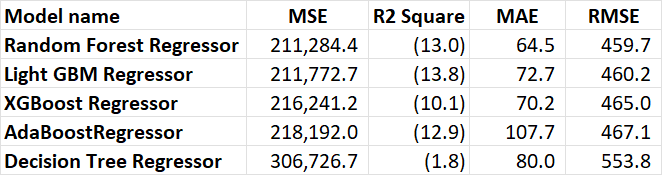

Randome Forest and Light GBM regressor models emerged as best model with lowest mean square error and highest R square.